# Inventory Management

## Business Context

is a store that sells various items, a family-owned in Janaúba-MG. The owner of the store is having problems with the inventory management and with the product offerings.

So you were hired as a Data Analyst, and your main challenge is to help the company optimize its inventory and products offerings.

The owner want the answer for the following questions?

1. What is the probablity that will sell X units a day?
2. What is the probability that I sell Y units a week?
3. Given the demand, what is the probability of stock-out if I arrange to have 5 units in stock every day?
4. What is the range which contains 90% of my possible demand?
5. After running a promotion, has the discount improved daily sales?
6. What products should I focus on?
7. What is the probability that I sell Z units a Month?

Solution Planning

- Collect the store sales data.
- Run an Exploratory Analysis.
- Find the high-revenues SKUs
- Determine their demand distriburion
- Define for each SKU the carrying 'too much' an carrying too 'little' inventory points.
- Use the demand distribution to answer the questions
- Write a report with the answers for the owner's questions and the lower and upper bound invetory for each SKU.






## Data Dictionary

Attribute|Description
---------|-----------
date| Date of the sale data. There are no holiday efects or store closures
store| Store ID
item| Item ID
sales| Number of items sold at a particular store on a particular date.

## 0.1 Imports

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st

In [93]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams['font.size'] = 15

## 0.2 Helper Functions

In [29]:
def num_summary(df):

    summary = df.agg(['min', 'median','mean', 'max', 'ptp', 'var', 'std', 'kurtosis', 'skew']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})
    summary['25th'] = np.quantile(df, 0.25, axis=0)
    summary['75th'] = np.quantile(df, 0.75, axis=0)

    return summary[['attributes', 'min', '25th', 'median', 'mean', '75th', 'max', 'range', 'var', 'std', 'kurtosis', 'skew']]

## 0.3 Load Data

In [19]:
types = {'store': np.uint16, 'item': np.uint16, 'sales': np.uint32}
data = pd.read_csv('../DATA/train.csv',low_memory=True, dtype=types, parse_dates=['date'])

In [20]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# 1.0 Data Description

In [21]:
df_desc = data.copy()

## 1.1 Data Dimension

In [22]:
print(f'Number of rows: {df_desc.shape[0]}')
print(f'Number of columns: {df_desc.shape[1]}')

Number of rows: 913000
Number of columns: 4


## 1.2 Data Types

In [23]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  uint16        
 2   item    913000 non-null  uint16        
 3   sales   913000 non-null  uint32        
dtypes: datetime64[ns](1), uint16(2), uint32(1)
memory usage: 13.9 MB


## 1.3 Missing Values

In [24]:
df_desc.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### 1.3.1 Handling Missing vlaues

In [25]:
# There are no missing values in the dataset

## 1.4 Duplicates

### 1.4.1 Handling Duplicates

In [26]:
df_desc.duplicated().sum()

0

No duplicates in our data.

## 1.5 Numerical Attributes

In [30]:
num_att = df_desc.select_dtypes(include=[float, np.uint32, np.uint16])

num_summary(num_att)

,attributes,min,25th,median,mean,75th,max,range,var,std,kurtosis,skew
0,store,1.0,3.0,5.5,5.500000,8.0,10.0,9.0,8.250009,2.872283,-1.224243,0.000000
1,item,1.0,13.0,25.5,25.500000,38.0,50.0,49.0,208.250228,14.430878,-1.200960,0.000000
2,sales,0.0,30.0,47.0,52.250287,70.0,231.0,231.0,829.505873,28.801144,0.509070,0.867112


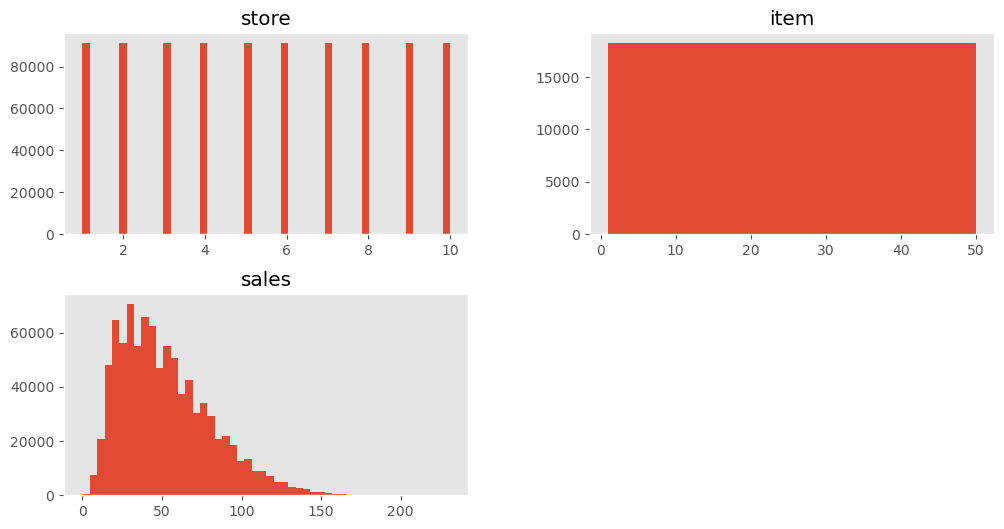

In [61]:
num_att.hist(figsize=(12, 6), bins=50, grid=False, histtype='stepfilled');

We have a minimum sales value of zero which is is strange.

In [67]:
df_desc.query('sales == 0')

,date,store,item,sales
64289,2014-01-15,6,4,0


## 1.6 Date

Checking if we have all the days between the first and the last day.

In [37]:
print(f'First date: {df_desc.date.min()}')
print(f'Last date: {df_desc.date.max()}')

First date: 2013-01-01 00:00:00
Last date: 2017-12-31 00:00:00


In [43]:
# days between = number of days - 1
(df_desc.date.max() - df_desc.date.min()).days == len(df_desc.date.unique()) - 1

True

# 2.0 Exploratory Data Analysis

In [ ]:
def plot_most_sales_by(df: pd.DataFrame, variable: str, target: str, max_categories: int):

    assert isinstance(df, pd.DataFrame), 'df must be a DataFrame'
    assert isinstance(variable, str), 'variable must be a string'
    assert isinstance(target, str), 'target must be a string'
    assert isinstance(max_categories, int), 'max_categories must be a integer'

    plot_df = df.groupby(variable).sum(numeric_only=True)[[target]].sort_values(target, ascending=False).reset_index()

    bar = sns.barplot(data=plot_df, x=variable, y=target, order=plot_df[variable][:max_categories])

    plt.bar_label(bar.containers[0], fmt='%d');

In [45]:
df_eda = df_desc.copy()

1. What are the top 10 most sold products?
2. Which store has the most sales?
3. What is the sales trend by year, month, and day?

### 1. What are the top 10 most sold products?

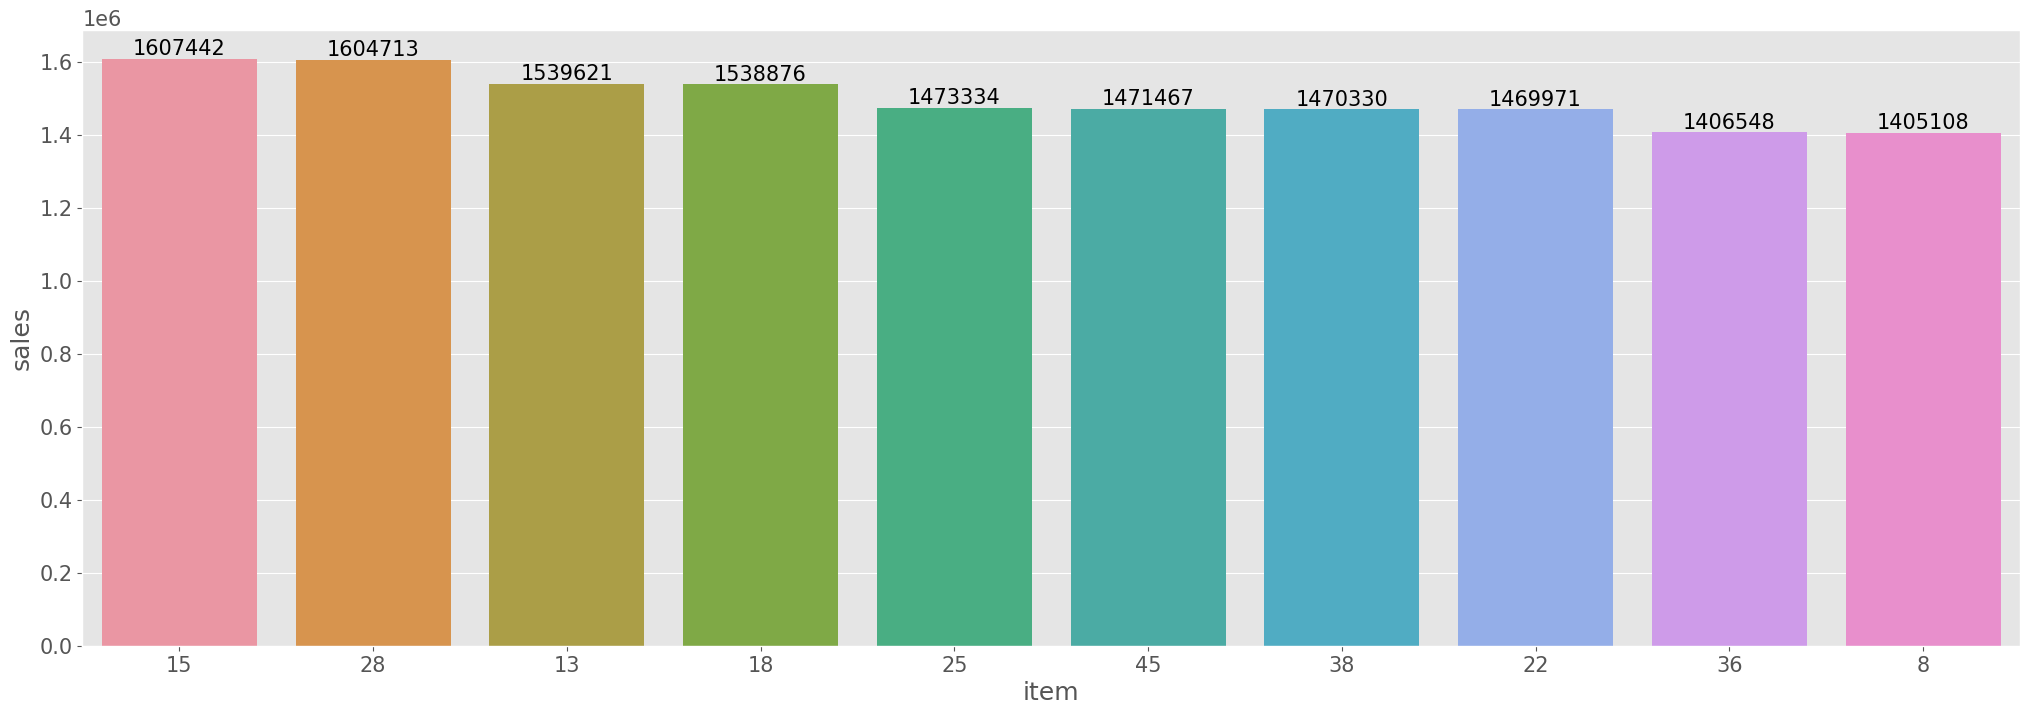

In [100]:
plot_most_sales_by(df=df_eda, variable='item', target='sales', max_categories=10)

### 2. Which stores has the most sales?

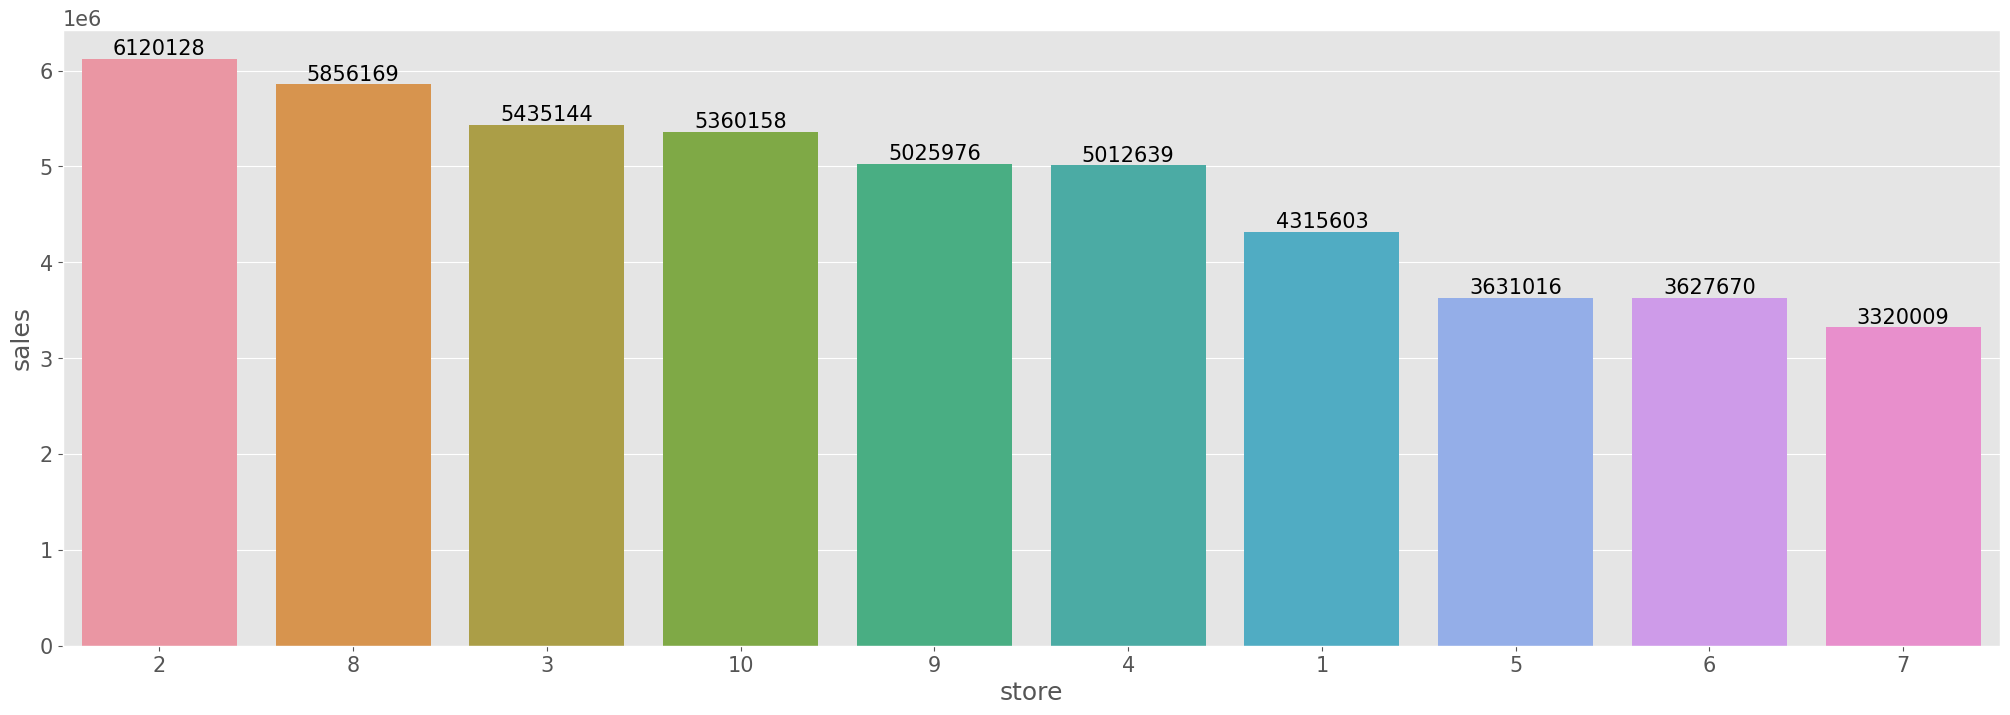

In [101]:
plot_most_sales_by(df=df_eda, variable='store', target='sales', max_categories=10)

## 3. What is the sales trend by year, month, and day?

In [105]:
df_series = df_eda.copy()[['date', 'sales']].set_index('date')

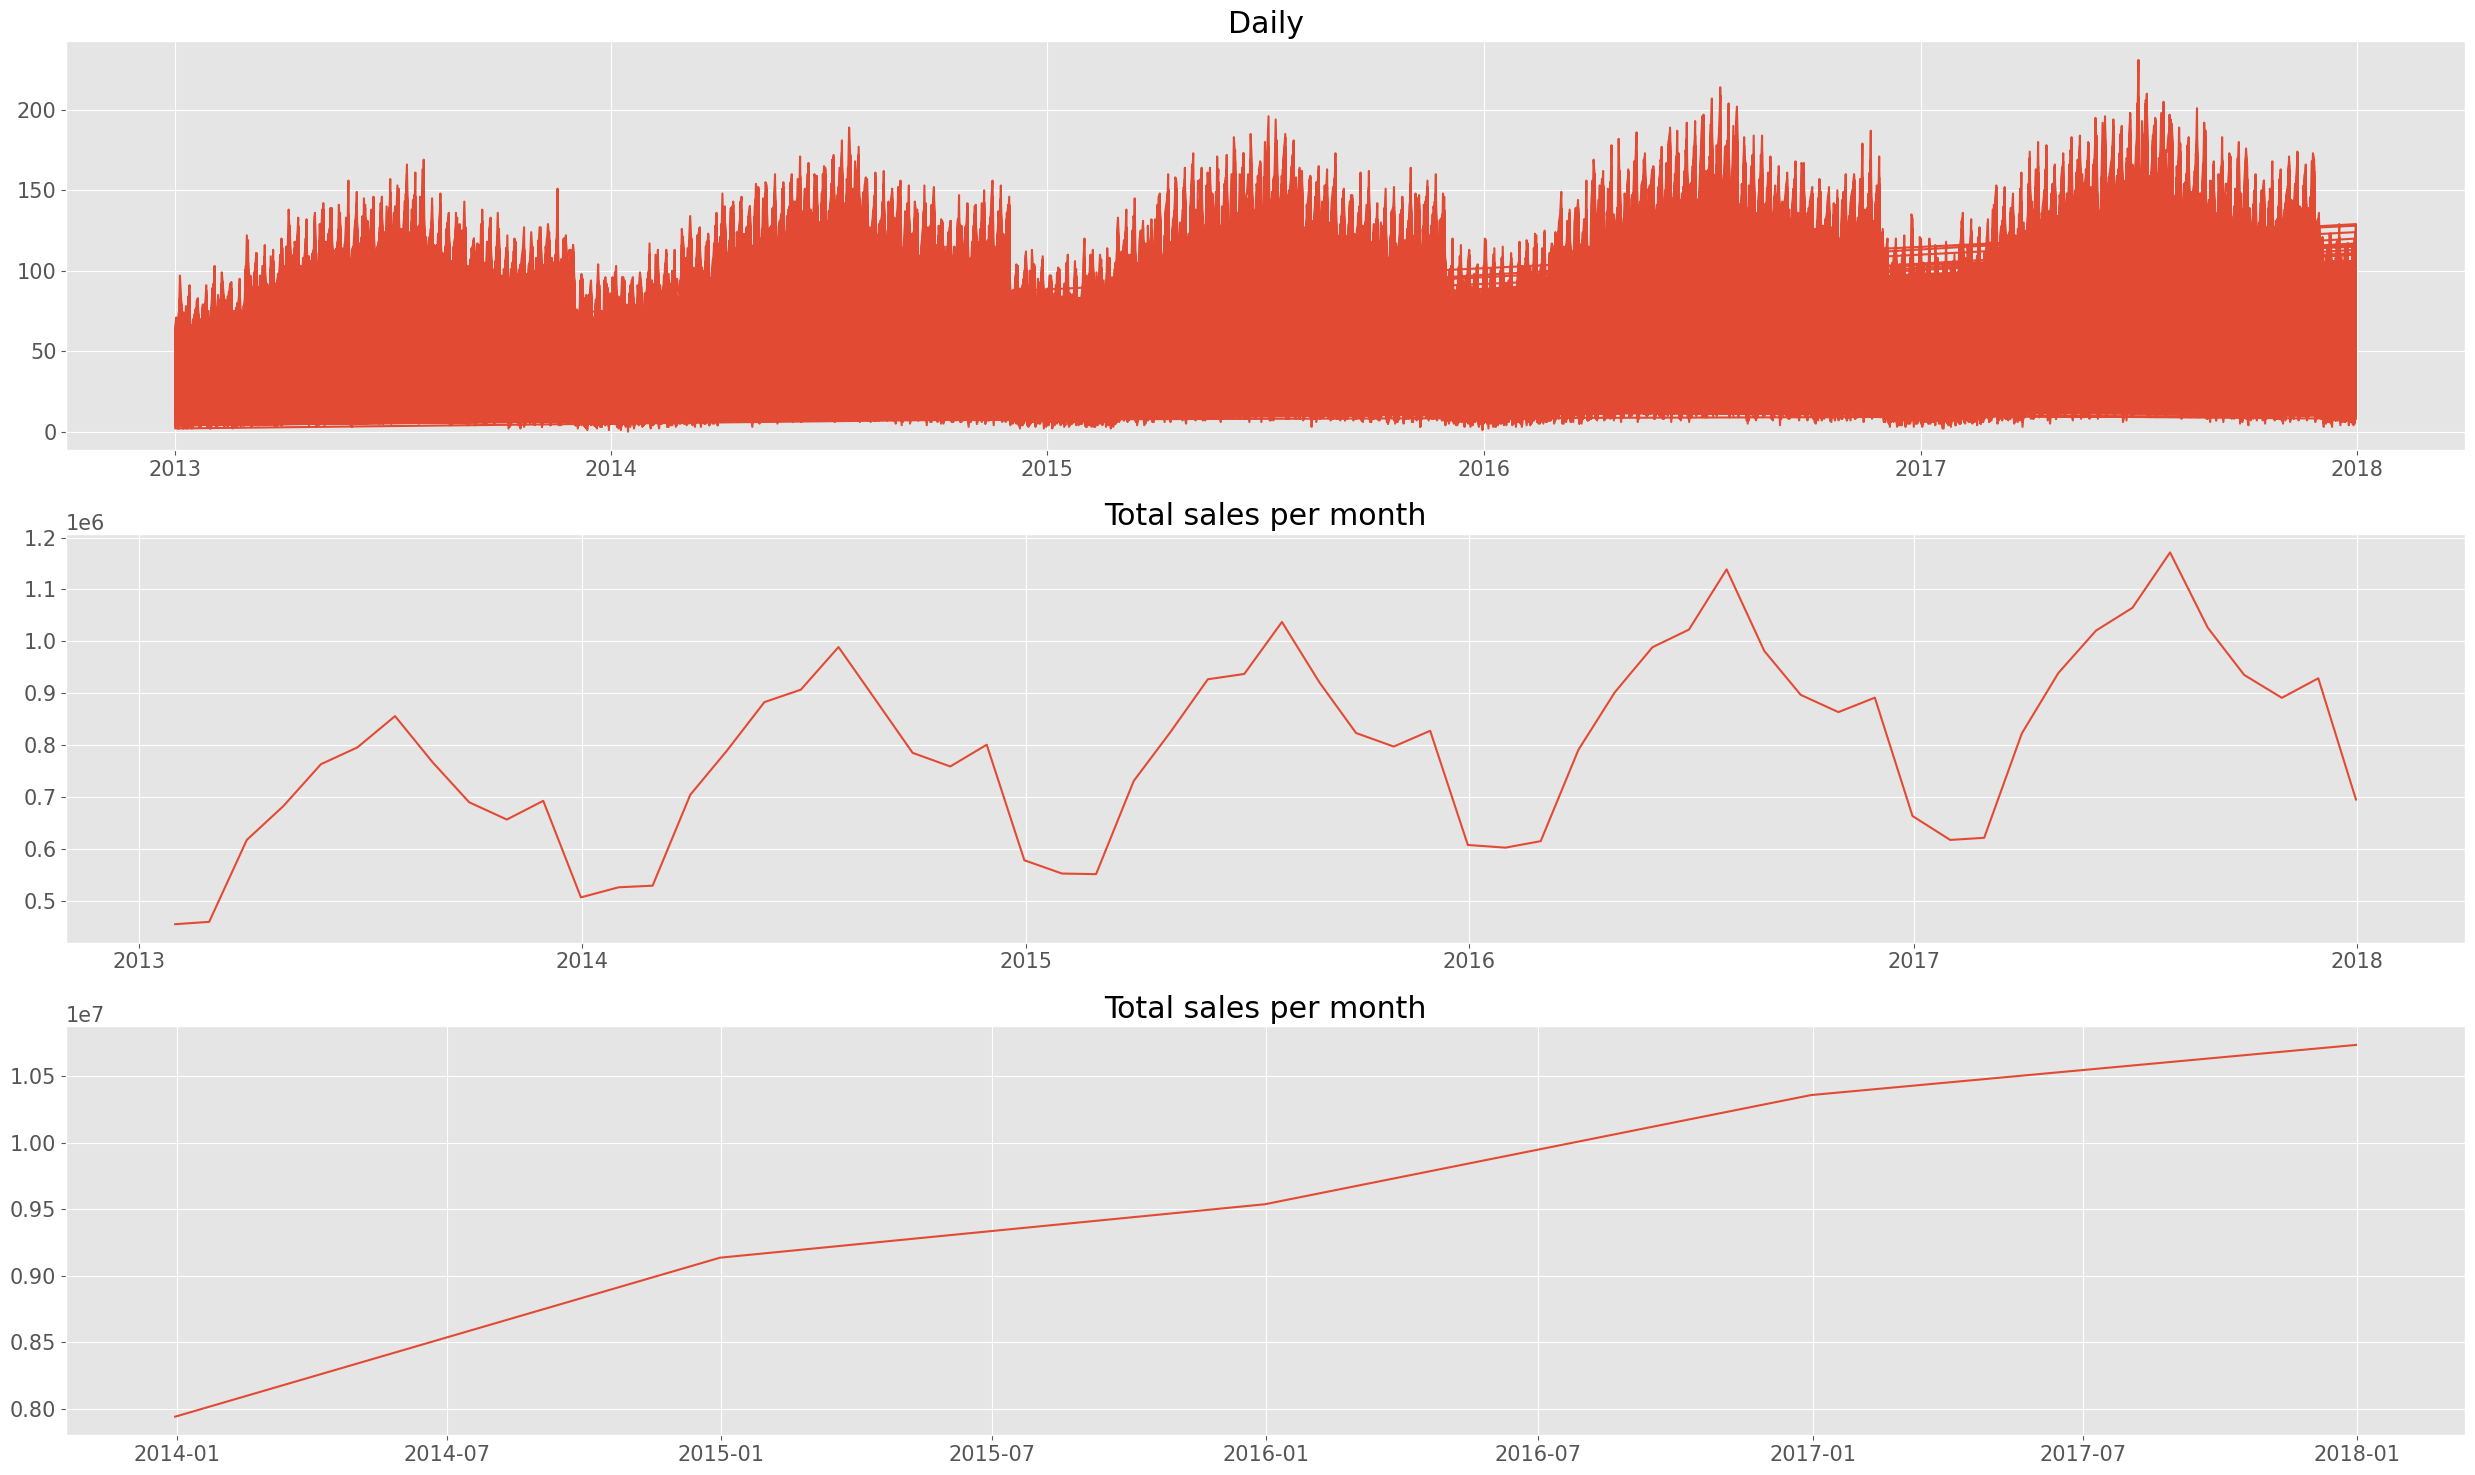

In [139]:
_, axis = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

axis[0].plot(df_series)
axis[0].set_title('Daily')

axis[1].plot(df_series.resample('m').sum())
axis[1].set_title('Total sales per month')

axis[2].plot(df_series.resample('a').sum())
axis[2].set_title('Total sales per year')
plt.tight_layout()

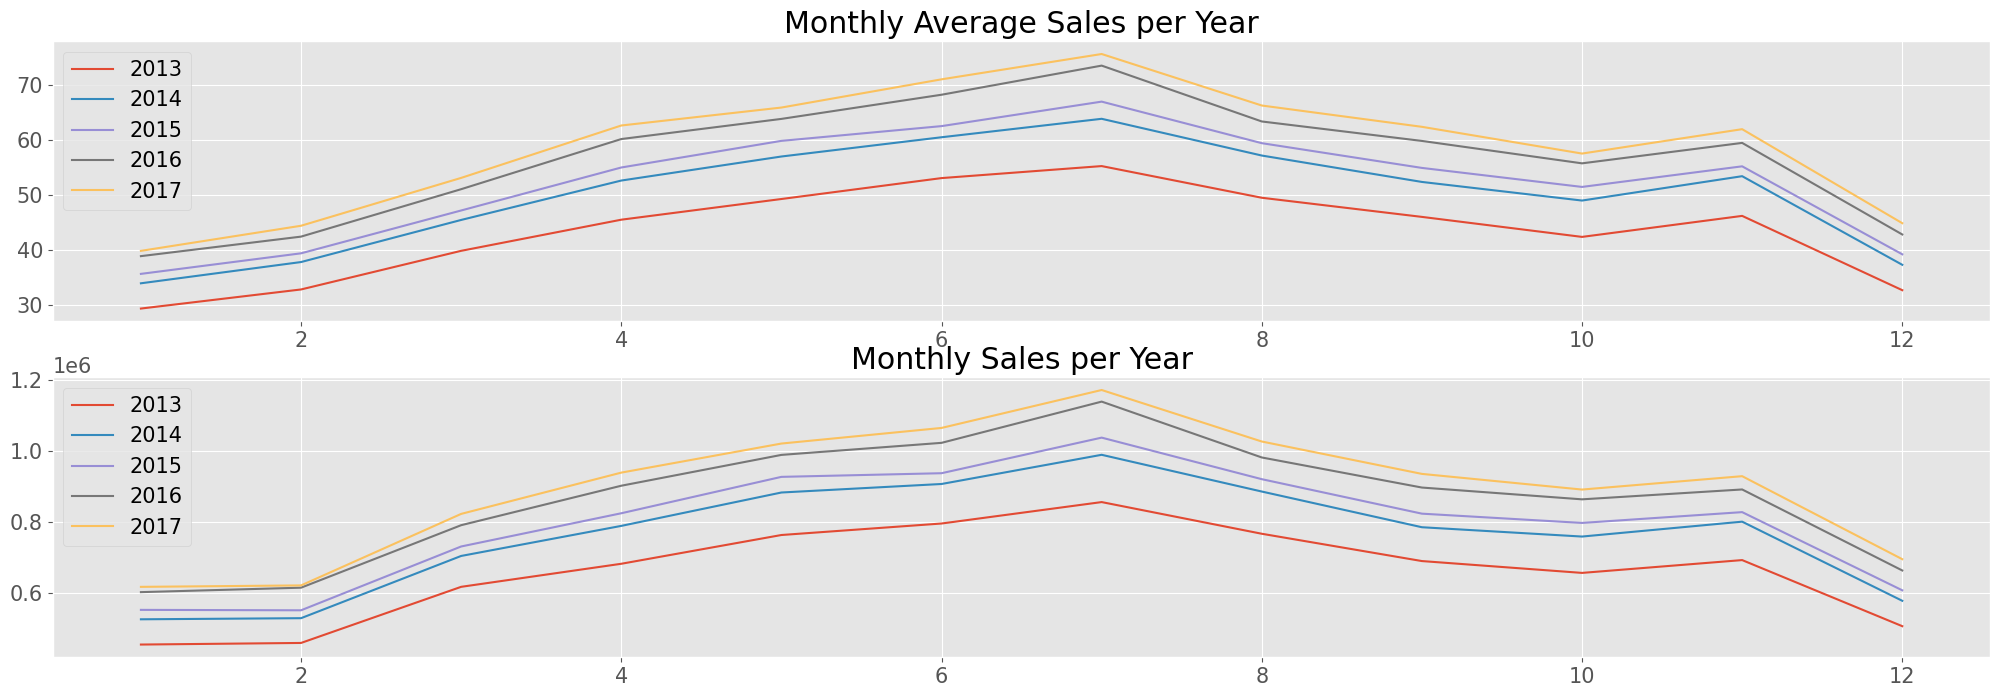

In [209]:
year_plot = df_series.copy()
year_plot['year'] = year_plot.index.year
year_plot['month'] = year_plot.index.month

year_plot = year_plot.groupby(['year', 'month']).agg(['mean', 'sum']).reset_index()
cols = year_plot.columns.to_list()

plt.subplot(2, 1, 1)
for year_ in year_plot.year.unique():

    plt.plot(year_plot.loc[year_plot['year'] == year_]['month'], year_plot.loc[year_plot['year'] == year_][cols[2]], label=year_)
plt.legend()
plt.title('Monthly Average Sales per Year')

plt.subplot(2, 1, 2)
for year_ in year_plot.year.unique():
    
    plt.plot(year_plot.loc[year_plot['year'] == year_]['month'], year_plot.loc[year_plot['year'] == year_][cols[3]], label=year_)
plt.legend()
plt.title('Monthly Sales per Year');

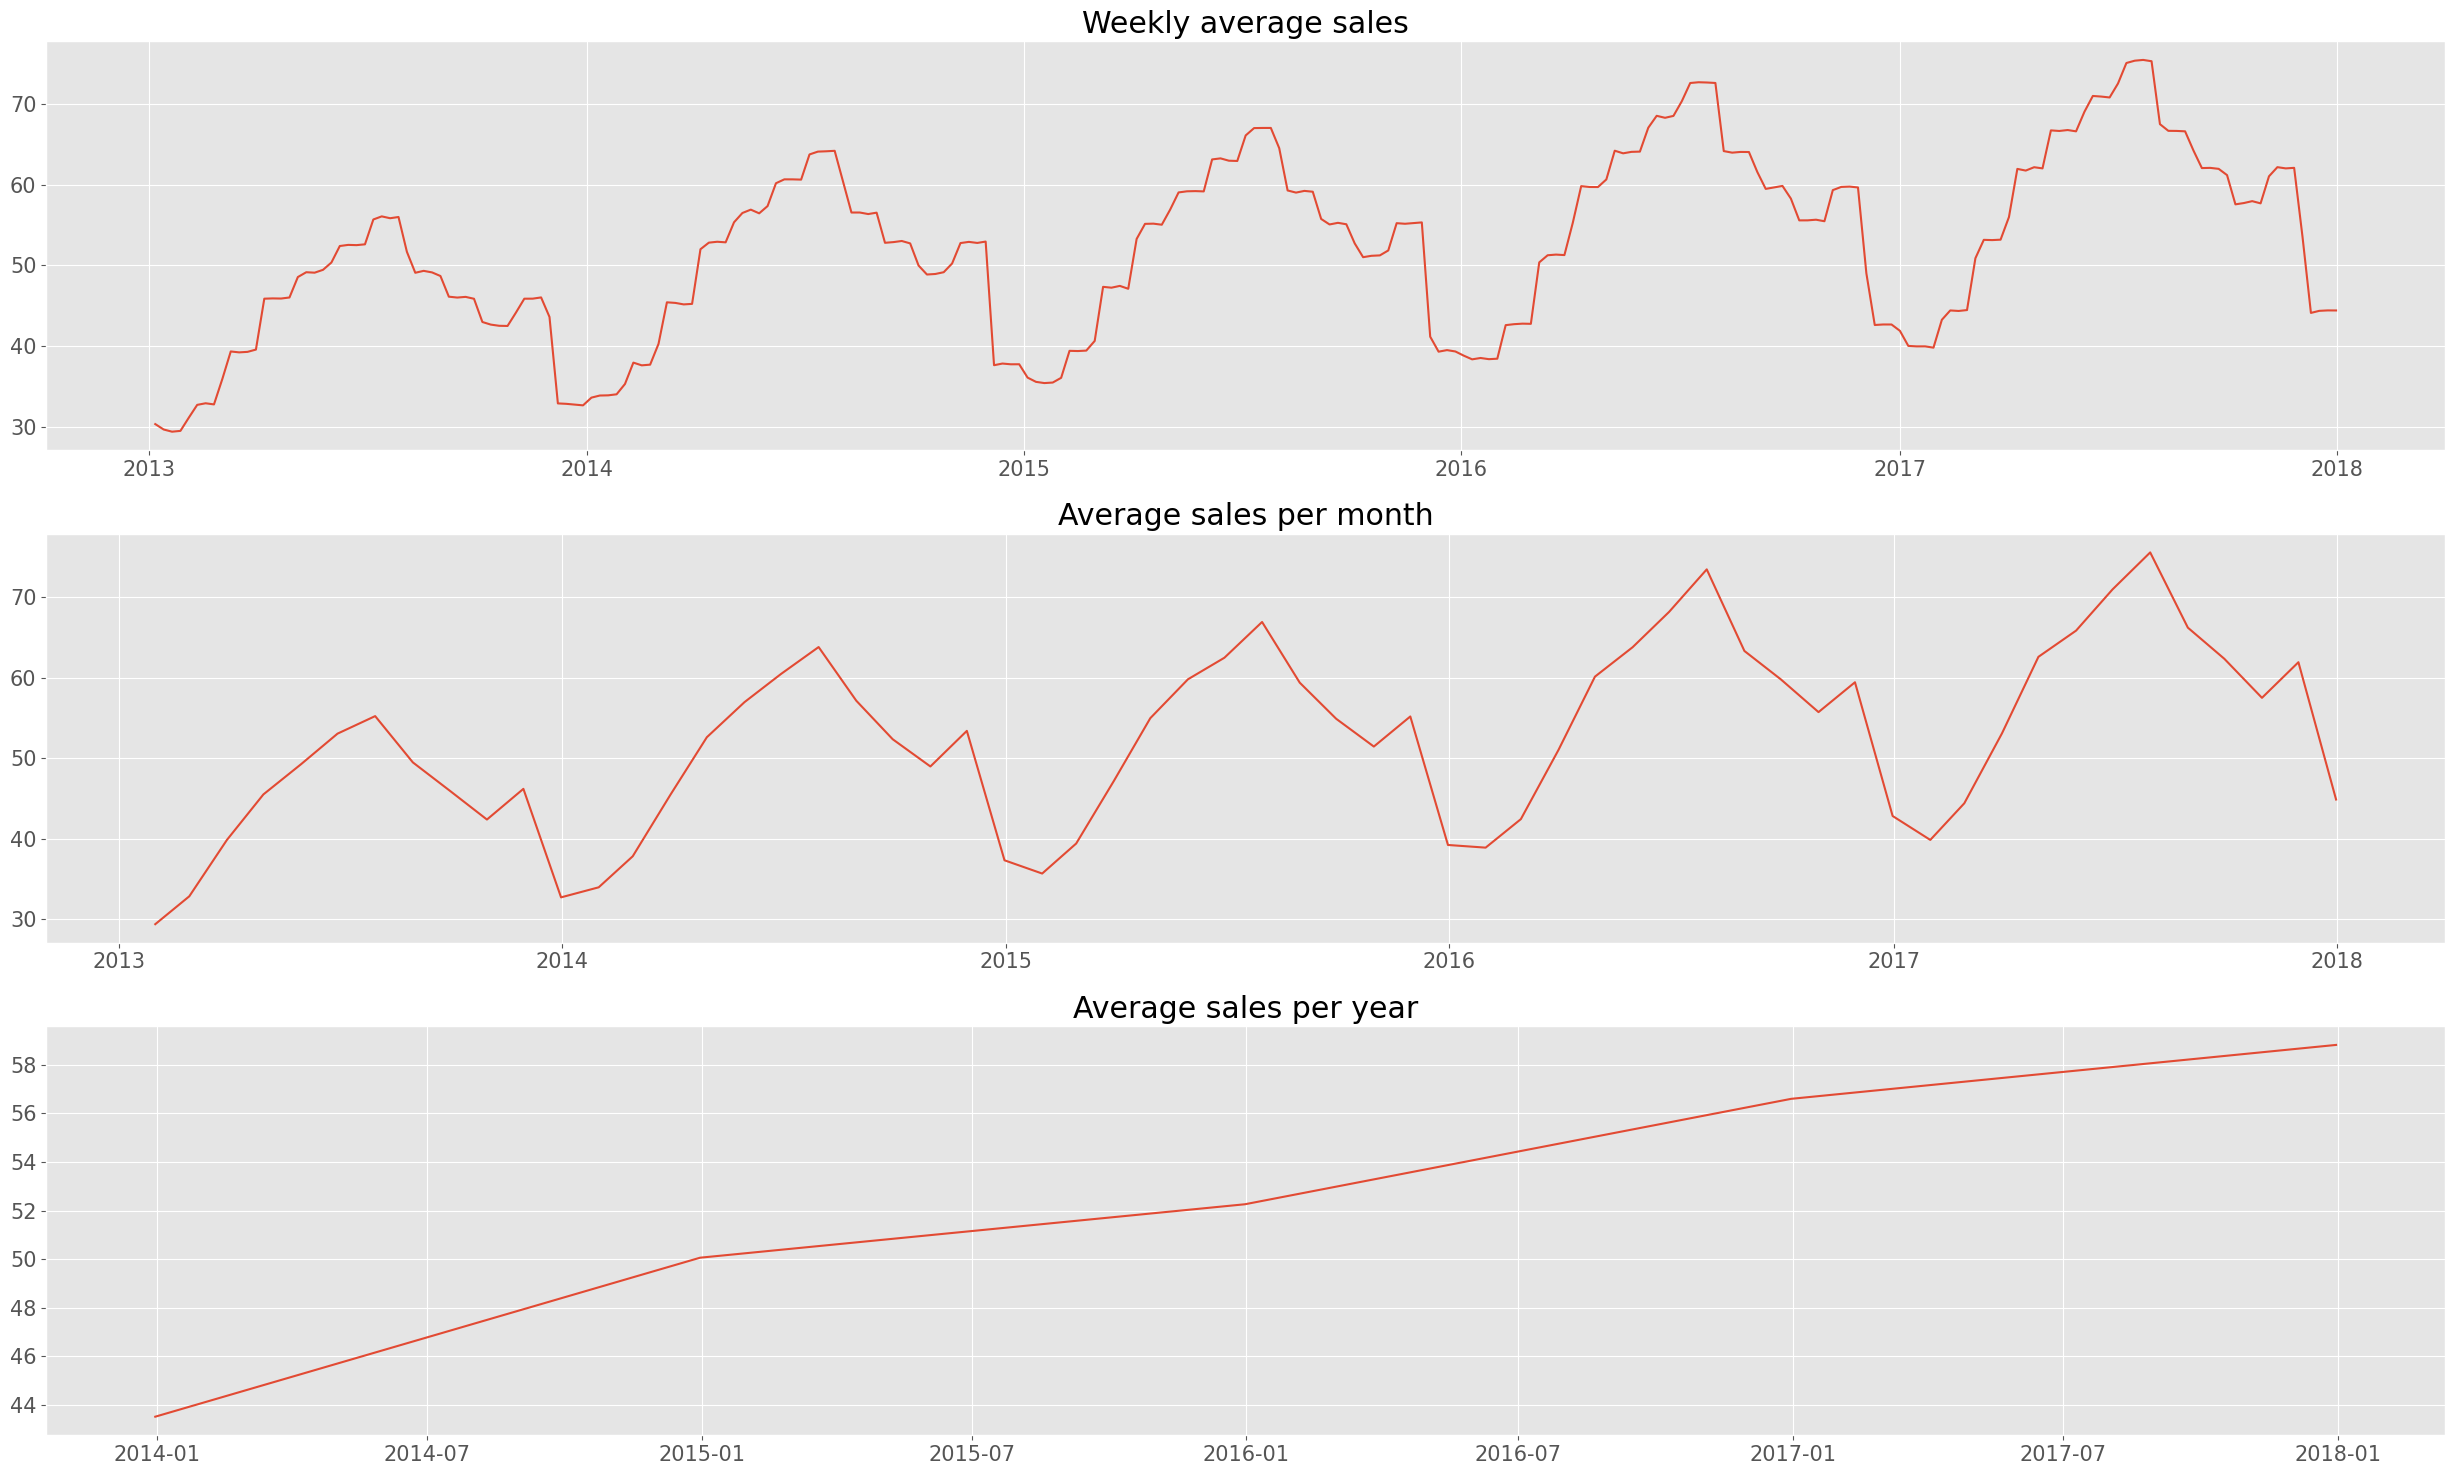

In [141]:
_, axis = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

axis[0].plot(df_series.resample('w').mean())
axis[0].set_title('Weekly average sales')

axis[1].plot(df_series.resample('m').mean())
axis[1].set_title('Average sales per month')

axis[2].plot(df_series.resample('a').mean())
axis[2].set_title('Average sales per year')
plt.tight_layout()

## Product Segmentation

Only the data from last year will be used.

In [215]:
sales_df = df_eda.copy()[df_eda.date.dt.year == 2017]

In [218]:
sales_by_prod = sales_df.groupby('item').sum(numeric_only=True).sort_values('sales', ascending=False).reset_index()

In [219]:
sales_by_prod

,item,store,sales
0,15,20075,361586
1,28,20075,360768
2,13,20075,346565
3,18,20075,346448
4,45,20075,331783
5,38,20075,331005
6,25,20075,330786
7,22,20075,329896
8,8,20075,316911
9,36,20075,316195


We will only work with the high-revenue SKUs.

We will use ABC segmentation, it goes as follows:

- Class A -> The products driving most revenue (products that generate 80% of the revenue).
- Class B -> The products in the middle (products that generate 15% of the revenue).
- Class C -> The products driving very little revenue (generate less than 5% of the revenue).

In [212]:
# Accumulated sales per produc
sales_df['acc_sales'] = sales_df.sales.cumsum()

sales_df['sales_perc'] = sales_df['acc_sales']/sales_df.sales.sum()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
